# 5.5 Sequences generation

Course's materials require a `tensorflow` version lower than the default one used in Google Colab. Run the following cell to downgrade TensorFlow accordingly.

In [ ]:
import os
def downgrade_tf_version():
    os.system("!yes | pip uninstall -y tensorflow")
    os.system("!yes | pip install tensorflow==2.12.0")
    os.kill(os.getpid(), 9)
downgrade_tf_version()

In [ ]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [ ]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

## Sampling

A recurrence Neural Network can be used as a Generative model once it was trained. Currently this is a common practice not only to study how well a model has learned a problem, but to learn more about the problem domain itself. In fact, this approach is being used for music generation and composition.

The process of generation is explained in the picture below:

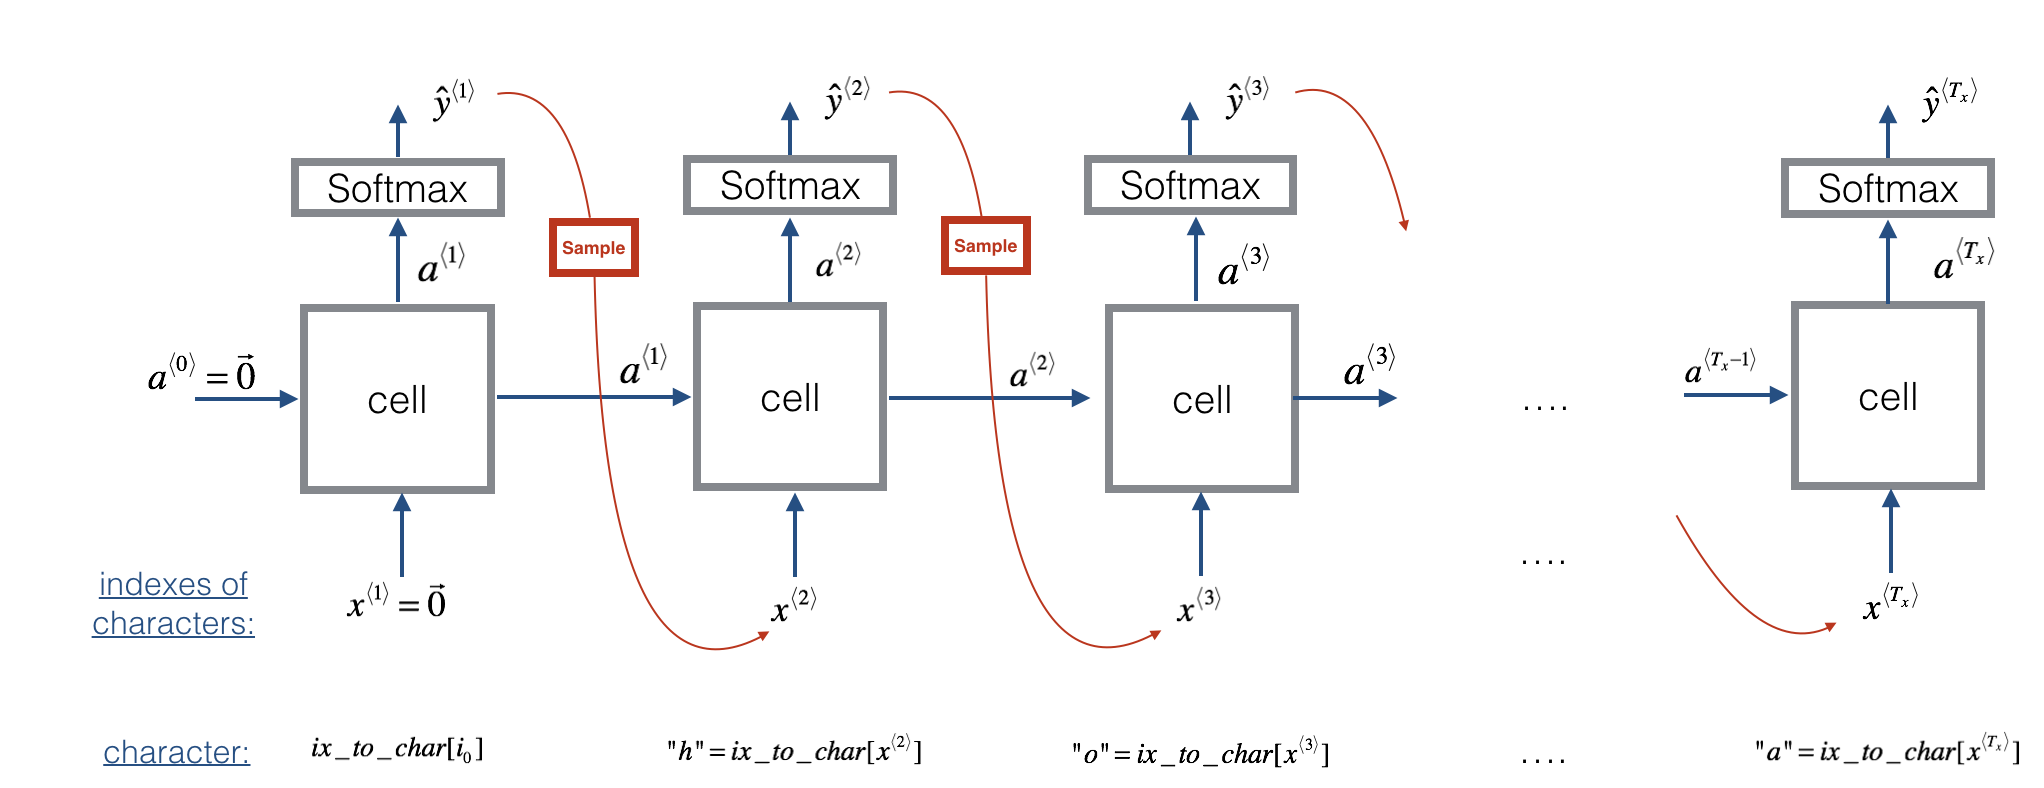

In [1]:
from IPython.display import Image
Image(filename='local/imgs/dinos3.png', width=800)
#<img src="local/imgs/dinos3.png" style="width:500;height:300px;">

Let's do an example:

In [1]:
import sys
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Masking
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
#This code is to fix a compatibility problem of TF 2.4 with some GPUs

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import nltk
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /home/julian/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [4]:
# load ascii text and covert to lowercase
raw_text = nltk.corpus.gutenberg.raw('bible-kjv.txt')

In [5]:
raw_text[100:1000]

'Genesis\n\n\n1:1 In the beginning God created the heaven and the earth.\n\n1:2 And the earth was without form, and void; and darkness was upon\nthe face of the deep. And the Spirit of God moved upon the face of the\nwaters.\n\n1:3 And God said, Let there be light: and there was light.\n\n1:4 And God saw the light, that it was good: and God divided the light\nfrom the darkness.\n\n1:5 And God called the light Day, and the darkness he called Night.\nAnd the evening and the morning were the first day.\n\n1:6 And God said, Let there be a firmament in the midst of the waters,\nand let it divide the waters from the waters.\n\n1:7 And God made the firmament, and divided the waters which were\nunder the firmament from the waters which were above the firmament:\nand it was so.\n\n1:8 And God called the firmament Heaven. And the evening and the\nmorning were the second day.\n\n1:9 And God said, Let the waters under the heav'

In [6]:
# create mapping of unique chars to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

In [7]:
char_to_int

{'\n': 0,
 ' ': 1,
 '!': 2,
 "'": 3,
 '(': 4,
 ')': 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '0': 9,
 '1': 10,
 '2': 11,
 '3': 12,
 '4': 13,
 '5': 14,
 '6': 15,
 '7': 16,
 '8': 17,
 '9': 18,
 ':': 19,
 ';': 20,
 '?': 21,
 'A': 22,
 'B': 23,
 'C': 24,
 'D': 25,
 'E': 26,
 'F': 27,
 'G': 28,
 'H': 29,
 'I': 30,
 'J': 31,
 'K': 32,
 'L': 33,
 'M': 34,
 'N': 35,
 'O': 36,
 'P': 37,
 'Q': 38,
 'R': 39,
 'S': 40,
 'T': 41,
 'U': 42,
 'V': 43,
 'W': 44,
 'Y': 45,
 'Z': 46,
 '[': 47,
 ']': 48,
 'a': 49,
 'b': 50,
 'c': 51,
 'd': 52,
 'e': 53,
 'f': 54,
 'g': 55,
 'h': 56,
 'i': 57,
 'j': 58,
 'k': 59,
 'l': 60,
 'm': 61,
 'n': 62,
 'o': 63,
 'p': 64,
 'q': 65,
 'r': 66,
 's': 67,
 't': 68,
 'u': 69,
 'v': 70,
 'w': 71,
 'x': 72,
 'y': 73,
 'z': 74}

In [8]:
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  4332554
Total Vocab:  75


To train the model we are going to use sequences of 60 characters and because of the data set is too large, we are going to use only the firs 200000 sequences.

In [9]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 60
dataX = []
dataY = []
n_chars = 200000
for i in range(0, n_chars - seq_length, 3):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Patterns:  66647


In [10]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [11]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [12]:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [13]:
X.shape

(66647, 60, 1)

Note that the entire dataset is used for training

In [14]:
model.fit(X, y, epochs=200, batch_size=128, verbose=1)

Epoch 1/200
521/521 [==============================] - 6s 8ms/step - loss: 3.2294
Epoch 2/200
521/521 [==============================] - 3s 5ms/step - loss: 2.8156
Epoch 3/200
521/521 [==============================] - 3s 7ms/step - loss: 2.6550
Epoch 4/200
521/521 [==============================] - 3s 6ms/step - loss: 2.5924
Epoch 5/200
521/521 [==============================] - 5s 9ms/step - loss: 2.5289
Epoch 6/200
521/521 [==============================] - 4s 8ms/step - loss: 2.4810
Epoch 7/200
521/521 [==============================] - 3s 7ms/step - loss: 2.4409
Epoch 8/200
521/521 [==============================] - 5s 10ms/step - loss: 2.4070
Epoch 9/200
521/521 [==============================] - 4s 8ms/step - loss: 2.3840
Epoch 10/200
521/521 [==============================] - 5s 9ms/step - loss: 2.3453
Epoch 11/200
521/521 [==============================] - 5s 9ms/step - loss: 2.3121
Epoch 12/200
521/521 [==============================] - 5s 9ms/step - loss: 2.2972
Epoch 13/200

521/521 [==============================] - 4s 9ms/step - loss: 0.5941
Epoch 197/200
521/521 [==============================] - 4s 7ms/step - loss: 0.8470
Epoch 198/200
521/521 [==============================] - 4s 8ms/step - loss: 0.5750
Epoch 199/200
521/521 [==============================] - 4s 7ms/step - loss: 0.5531
Epoch 200/200
521/521 [==============================] - 4s 7ms/step - loss: 0.5230


In [15]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [16]:
# pick a random seed
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
" s, saying, Jacob hath taken
away all that was our father's;  "
and he hoeeml in uher ph thi liude tf mrte iv mes.hrst. 
20:3 And the senea tayt,ov Suonpha, whei sho ln hed teme upene thkt the gare of thed, 
6::7 Tnenef tha woin oa Sebha Icble tee Bumpae,ii Noarcrhr, 
26:2 And Eoruel dngu, and Hamaa' and Jaiae, and Jahlap, and Jedmah, and Tekah,
and Tekaha, and Teblhc: 36:1 And AnzaNa aid Bihi tii teie  shecn ia haa mam, and toet hem: ant there Ara cadh hamk aw uhr fnadmt'onth mi  and seee in pas  end hete it
unto mh.
and siat kere hete tham
 
20:61 Nnt mhe elies wf Loau,w gifser Gamoh  ae shen N bayerees tvto the eeyh of my cirthed.
and dare nl uhe
drd  and hit iind fo?thor hidst, and he tas teet it wate
tp tef khrhe if mae wo hr deci;s aarhmt. 
15:54 And the men woie oht wwon thes hs the coes of Rodn: anr the same grsmd mor finye fir 
and hes is c phlel sf dr ters woan
fo hanher; aea uh tyelk ny sinv  wha hrued afuer hfm,

32:18 And the men woie on ham tien, sh c mivt ma dadkt

### The result is not what we expected mainly because of three resons:

- The model requires to be trained with a larger dataset in order to better capture the dynamics of the language.
- During validation it is not recommendable to select the output with maximum probability but to use the output distribution as parameters to sample from a multinomial distribution. This avoid the model to get stuck in a loop.
- A more flexible model with more data could get better results. 

In [17]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

## Using a more complex model with the whole dataset

This problem is complex computationally speaking, so the next model was run using GPU.

In [18]:
batch_size = 128
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(LSTM(256))
model.add(Dropout(rate=0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

More data could produce memory erros so we have to create a data_generator function for the problem:

In [19]:
class KerasBatchGenerator(object):

    def __init__(self, data, num_steps, batch_size, vocabulary, skip_step=1):
        self.data = data
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set
        self.skip_step = skip_step
        
    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps, 1))
        y = np.zeros((self.batch_size, self.vocabulary))
        while True:
            for i in range(self.batch_size):
                if self.current_idx + self.num_steps >= len(self.data):
                    # reset the index back to the start of the data set
                    self.current_idx = 0
                seq_in = self.data[self.current_idx:self.current_idx + self.num_steps]
                x[i, :, 0] = np.array([char_to_int[char] for char in seq_in])/ float(n_vocab)
                seq_out = self.data[self.current_idx + self.num_steps]
                temp_y = char_to_int[seq_out]
                # convert all of temp_y into a one hot representation
                y[i, :] = np_utils.to_categorical(temp_y, num_classes=self.vocabulary)
                self.current_idx += self.skip_step
            yield x, y

In [20]:
batch_size = 128
train_data_generator = KerasBatchGenerator(raw_text, seq_length, batch_size, n_vocab, skip_step=3)

In [21]:
#model.fit_generator(train_data_generator.generate(), epochs=30, steps_per_epoch=n_chars/batch_size)
model.fit(X, y, epochs=200, batch_size=32)

Epoch 1/200
2083/2083 [==============================] - 26s 12ms/step - loss: 3.0367
Epoch 2/200
2083/2083 [==============================] - 24s 11ms/step - loss: 2.5037
Epoch 3/200
2083/2083 [==============================] - 25s 12ms/step - loss: 2.3439
Epoch 4/200
2083/2083 [==============================] - 27s 13ms/step - loss: 2.2347
Epoch 5/200
2083/2083 [==============================] - 26s 12ms/step - loss: 2.1483
Epoch 6/200
2083/2083 [==============================] - 24s 11ms/step - loss: 2.0631
Epoch 7/200
2083/2083 [==============================] - 23s 11ms/step - loss: 1.9892
Epoch 8/200
2083/2083 [==============================] - 27s 13ms/step - loss: 1.9368
Epoch 9/200
2083/2083 [==============================] - 32s 16ms/step - loss: 1.8735
Epoch 10/200
2083/2083 [==============================] - 28s 13ms/step - loss: 1.8218
Epoch 11/200
2083/2083 [==============================] - 29s 14ms/step - loss: 1.7650
Epoch 12/200
2083/2083 [============================

2083/2083 [==============================] - 28s 14ms/step - loss: 0.9642
Epoch 189/200
2083/2083 [==============================] - 28s 14ms/step - loss: 0.9633
Epoch 190/200
2083/2083 [==============================] - 29s 14ms/step - loss: 0.9460
Epoch 191/200
2083/2083 [==============================] - 25s 12ms/step - loss: 0.9605
Epoch 192/200
2083/2083 [==============================] - 29s 14ms/step - loss: 0.9480
Epoch 193/200
2083/2083 [==============================] - 26s 13ms/step - loss: 0.9451
Epoch 194/200
2083/2083 [==============================] - 19s 9ms/step - loss: 0.9382
Epoch 195/200
2083/2083 [==============================] - 20s 10ms/step - loss: 0.9595
Epoch 196/200
2083/2083 [==============================] - 24s 11ms/step - loss: 0.9227
Epoch 197/200
2083/2083 [==============================] - 24s 11ms/step - loss: 0.9242
Epoch 198/200
2083/2083 [==============================] - 17s 8ms/step - loss: 0.9273
Epoch 199/200
2083/2083 [=======================

As we saw in previous classes, the model trained using batch_input_shape requires a similar batch for validation, so in order to evaluate the model using a single sequence, we have to create a new model with a batch_size = 1 and pass on the learnt weights of the first model to the new one. 

In [22]:
# re-define the batch size
n_batch = 1
# re-define model
new_model = Sequential()
new_model.add(LSTM(256, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), return_sequences=True))
new_model.add(Dropout(rate=0.2))
new_model.add(LSTM(256))
new_model.add(Dropout(rate=0.2))
new_model.add(Dense(y.shape[1], activation='softmax'))
# copy weights
old_weights = model.get_weights()
new_model.set_weights(old_weights)
# compile model
new_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [23]:
# pick a random seed
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
    x = np.reshape(pattern, (1, seq_length, 1))
    x = x / float(n_vocab)
    prediction = new_model.predict(x, verbose=0)[0]
    index = sample(prediction, 0.3)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
" e said, Is not he rightly named Jacob? for he hath
supplante "
d him anl that which

/home/julian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


 was in his son.

26:15 And the seven oe the man of Earaham stoedn them ont, and grom the land of Cgypt.

40:48 And the waters were iim to the len of the darth, and the sons of Esau, and the cameed a samoon in the land of Cgypt. 
44:48 And the seventg day wat anl that he had mado of to drenk aerrreng, and the camees,
and the famene which he had spoken of the man; and he said, She caughter ald the diildren of Searaoh iis sesvants,
and said unto him, Where oe my mister Aaraham and the food of the land of Cgypt, and the wasers were the seven go twene betuid, and sent me to thei fown to the mend of Cgypt, and seid unto him, There on the land of Cgypt, and with thee and the men shall be mnten.

34:32 And the cemer were there things, and taid unto him, There oe my mister said unto him, Tho hs the land of Cgypt, and the farthin of the hand of Egypt, and terv them in the land of Cgypt. 
44:40 And the sons of Dasaham's sarvant, and said unto Abramam, Iehold, ie and the theii
Done.


In [110]:
# serialize model to JSON
model_json = new_model.to_json()
with open("modelgenDNNLSTM.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
new_model.save_weights("modelgenDNNLSTM.h5")
print("Saved model to disk")

Saved model to disk
